# Simple model without closed-form solution

We based our previous chapters on an intuitive example: tossing a coin and trying to find whether the probability of head is 0.5, i.e. whether our coin is biased. And we saw that we can use the Bayes Theorem to obtain the probability of each value of $\Theta$ based on the observed data, based on which we can reach a principled decision.

In this chapter, we will use another example to illustrate that even for rather simple models, some terms of the Bayes theorem might not have an analytical solution (you will see what that means in a bit ), making computing the posterior difficult. Importantly, the reason we introduce that is to motivate the use of the bag of tricks this book is about: **Variational Laplace**. Once you understand why we can't simply solve the equation, it should be more intuitive to understand why we need to call on seemingly unrelated concepts.

The example we will use is also based on a simple question: is the length of penguins flippers related to their body mass? The reason we use this problem is two folds. For one, it enables us to illustrate the difficulties of Bayesian statistics with one of the most general model there is: the linear mixed model, which is also the most important for people reading coming from psychology and neuroscience. But also, it might be familiar from other tutorials online because of the Palmer penguin data set, which is used across many tutorials to illustrate basic principles of stats. In this chapter, we will rely on simulation rather than on the actual dataset, but we will get back to the actual data set in a later chapter. 

## The linear model:
To investigate this problem, we will use a linear model, which is defined as:

$$y = \beta_{0} + \beta_{1}x_{1} + \epsilon$$

Where:
- y: the data. In our example, that would be the body mass of the penguin
- $x_{1}$: a correlate. In our example, that would be the flipper length
- $\beta_{1}$: correlation coefficient. If the flipper length is related to the mass of the penguin, then the body weight may be $\beta_{1}$ times the flipper length
- $\beta_{0}$: intercept. If there is a linear relationship between the body weight and the flipper of the penguin, there may be an offset in that relationship (we will see below that that looks like)
- $\epsilon$ error term. The relationship between the flipper length and the body weight probably isn't 1 to 1, so there will be some error remaining that isn't explained by our model

When cast in this way, we can rephrase our question **'is the length of penguins flippers related to their body mass?'** in a more formal way, by saying: **is the parameter $\beta_1$ significantly different from 0?** Just as in our coin toss problem where we wanted to establish the true probability of getting head (to see if it is more or less 0.5), we here want to draw an inference about the true value of $\beta_1$ based our data. But as was the case with our coin toss example, because we are dealing with some degrees of randomness, we can never be sure of what the true value of $\beta_1$ is. Instead, what we have to try to establish is what is the probability of each value of $\beta_1$ based on our data. So once again, we need to apply the Bayes theorem to find:

$$P(\Theta|y)$$

Where this time $\Theta$ are the parameters $\beta_{1}$ and $\beta_{0}$. You might wonder: we only care about $\beta_{1}$, so why worry about $\beta_{0}$. The main reason is that while $\beta_{0}$ doesn't matter for our problem, it will for many other. And while in the current model we have only two betas, there are linear models with many more $\beta$. We will therefore use this example to illustrate that the $\Theta$ in the Bayes theorem can refer to many parameters of a single model and how $P(\Theta|y)$ can refer to the probability of many parameters at once.

## Simulating our data: the linear model in action
Let's suppose that there is a positive correlation between the flipper length and the weight of the penguin. That would make sense, because it seems logical that penguin with larger flippers would be heavier. And also, as we said, we probably won't have a perfect relationship between flipper length and penguin's weight, so there will be some error remaining. So say we have a correlation of 0.19, plus some error, and an intercept of 0, the data would look something like that:

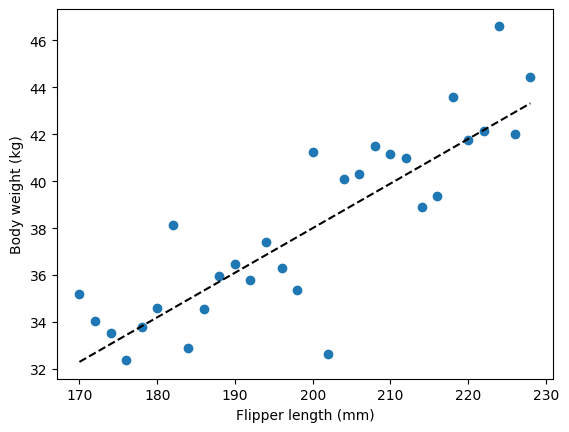

In [175]:
import numpy as np
import matplotlib.pyplot as plt

def linear_mdl(x, beta_0, beta_1, error_mu, error_sigma):
    y = beta_0 + beta_1 * x + np.random.normal(error_mu, error_sigma, size=x.shape[0])
    return y

# Define the parameters for our simulation:
flipper_length_mm = np.arange(170, 230, 2)  # Let's say we collected the flipper length of penguins and that these are between 170 and 230mm
beta_0 = 0  # Intercept
beta_1 = 0.19  # Regression coefficient between flipper length and body weight 
error_mu = 0  # Mean error term
error_sigma = 2  # Error term spread

# Simulate the data:
y = linear_mdl(flipper_length_mm, beta_0, beta_1, error_mu, error_sigma)

# Plot the data:
fig, ax = plt.subplots()
ax.scatter(flipper_length_mm, y)  # Plot the simulated data
ax.plot(flipper_length_mm, beta_0 + beta_1 * flipper_length_mm, color='k', linestyle='--', label='Regression line')  # Plot the regression line
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body weight (kg)')
plt.show()
plt.close()

There we go, we have generated semi-realistic data: penguin flippers size is correlated with their body weights. A penguin with flippers of 200mm is going to weight around 36-38kg, while a penguin with flipper lengths of 170mm is most likely going to weight around 32-34kg. That doesn't seem too crazy, but full disclosure I am not a penguin experts, so I have no idea. In comparison, our model could also have a non-zero intercept:

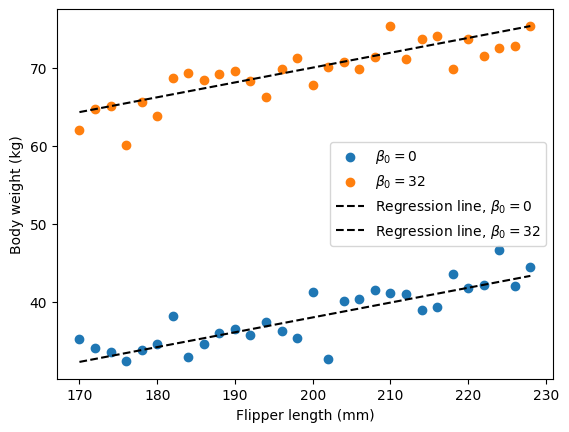

In [176]:
# Define the parameters for our simulation:
non_zero_beta_0 = 32  # Intercept

# Simulate the data:
y_intercept = linear_mdl(flipper_length_mm, non_zero_beta_0, beta_1, error_mu, error_sigma)

# Plot the data:
fig, ax = plt.subplots()
ax.scatter(flipper_length_mm, y, label='$\\beta_0=0$')  # Plot the simulated data
ax.scatter(flipper_length_mm, y_intercept, label='$\\beta_0=32$')  # Plot the simulated data
ax.plot(flipper_length_mm, 0 + beta_1 * flipper_length_mm, color='k', linestyle='--', label='Regression line, $\\beta_0=0$')  # Plot the regression line
ax.plot(flipper_length_mm, non_zero_beta_0 + beta_1 * flipper_length_mm, color='k', linestyle='--', label='Regression line, $\\beta_0=32$')  # Plot the regression line
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body weight (kg)')
ax.legend()
plt.show()
plt.close()

You can see that when we modulate the intercept term, we move the line up or down. The intercept as the name indicates refers to the value on the y axis at which our regression line crosses when x is 0. In our penguin example, you can think about it like this: if we had a hypothetical penguin of flipper length 0, would that penguin also weight 0 kg? When you draw your regression line, imagine you extend it until a flipper length of 0mm, the intercept is the weight of such a hypothetical 0mm length penguin according to our model.

There is another very important thing to understand here. If you have used linear models in the past, you might understand them only as a statistical tool: you fit the model to your data, compute some statistics (such as p values) on the beta coefficient to then conclude 'yes there is a relationship between these two variables'. However, a linear model is first and foremost a generative model for the data. You are basically stating a hypothesis that your dependent variable (y) is equal to the independent variable(s) (x) weighted by a particular coefficient ($\beta$) plus some noise. The fitting procedure is used to find the parameters of the model based on the data (more on that later). As we did above, you can also use the linear model to simulate data, by setting parameters that you think are reasonable. You can also fit the model to true data to extract the parameters, and then use the exact same parameters to simulate data based on these realistic parameters (I will show how that's done below). The concept of **generative model** will become very important in the later chapters of the book, so make sure that this is clear (if it's not, you can drop an issue on github to request more detailed info ;)

### Fitting a linear model to retrieve the parameters based on the data

Before we go into the details of the Bayesian part, I will spend a few paragraphs describing the inner workings of a linear model. Feel free to skip if you are very familiar with those. But I would encourage you to read it anyways, because some of the concepts relevant to explain a linear model are very relevant for the Bayesian part that comes later.

When we fit a linear model, we try to find values for the parameters of our model ($\beta_{0}$ and $\beta_{1}$) that minimize the error, that is how off the value predicted by our model are from the actual data. If the $\beta_{1}$ parameter that yields the smallest error is large, chances are the two variables you are looking at are correlated.

Trying to minimize the error means trying to make the distance between each dot and the regression line as small as possible. Here is way to vizualize it:

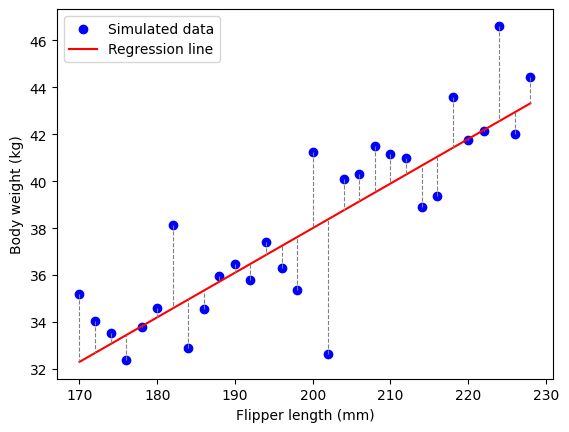

In [177]:
# Plot the data and regression line
fig, ax = plt.subplots()
ax.scatter(flipper_length_mm, y, label='Simulated data', color='blue')
ax.plot(flipper_length_mm, beta_0 + beta_1 * flipper_length_mm, color='red', label='Regression line')
# Add horizontal lines connecting each data point to the regression line
for i in range(len(flipper_length_mm)):
    ax.plot([flipper_length_mm[i], flipper_length_mm[i]], [y[i], beta_0 + beta_1 * flipper_length_mm[i]], color='gray', linestyle='--', linewidth=0.8)
# Set labels and legend
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body weight (kg)')
ax.legend()
# Show plot
plt.show()
plt.close()

That way, you can see that for each penguin (i.e. each dot), their weight is $\beta_1 * Flipper\ Length + some\ error$. If you take the left most dot, the weight is $170*0.19=32.3kg$ to which you add (or sutract) some error. That little something is the error, and we need to find the parameter of our model so that the sum of the vertical distance between each dot and the regression line is as small as possible. Because we are working with simulated data, the best parameters should be close to the one we selected. And if we choose any other parameters (different values for $\beta_0$ and $\beta_1$), the error should be larger:

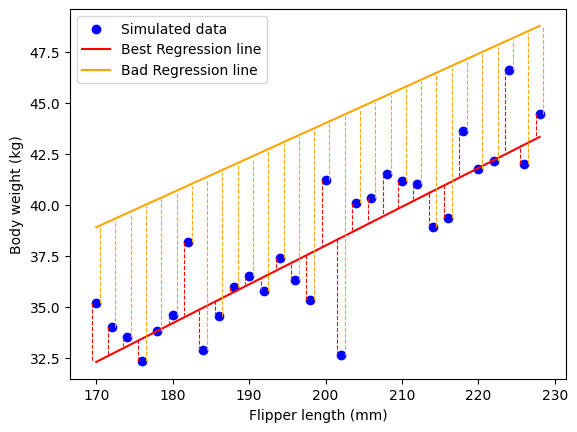

In [178]:
# Create wrong parameters:
wrong_beta_0 = 10
wrong_beta_1 = 0.17

fig, ax = plt.subplots()
ax.scatter(flipper_length_mm, y, label='Simulated data', color='blue')
ax.plot(flipper_length_mm, beta_0 + beta_1 * flipper_length_mm, color='red', label='Best Regression line')
ax.plot(flipper_length_mm, wrong_beta_0 + wrong_beta_1 * flipper_length_mm, color='orange', label='Bad Regression line')
# Add horizontal lines connecting each data point to the regression line
for i in range(len(flipper_length_mm)):
    ax.plot([flipper_length_mm[i]-0.5, flipper_length_mm[i]-0.5], [y[i], beta_0 + beta_1 * flipper_length_mm[i]], color='red', linestyle='--', linewidth=0.8)
    ax.plot([flipper_length_mm[i]+0.5, flipper_length_mm[i]+0.5], [y[i], wrong_beta_0 + wrong_beta_1 * flipper_length_mm[i]], color='orange', linestyle='--', linewidth=0.8)
# Set labels and legend
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body weight (kg)')
ax.legend()
# Show plot
plt.show()
plt.close()

You can see that the distance between the orange line and each dot is larger than the distance between the red line for most points. There are a few points where that is not the case, but on average, it's easy to see that red line does a better job than the orange one. Formally, when we try to minimize the error, we try to minimize the **residual sum of square error**:

$$RSS = \sum_{i=1}^{n}(y_i-\hat{y}_i)^2$$

Which is basically saying we try to find the parameters $\beta_0$ and $\beta_1$ such that the sum of the difference between each blue dot ($y_i$) and the value predicted by the line ($\hat{y_i}$) is as small as possible. And we take the square of the difference such that it doesn't matter if the prediction is more or less than the true value. So you can imagine that fitting a linear model is trying all possible combinations of values of $\beta_0$ and $\beta_1$ (and other $\beta$ if you have several regressors) and for each compute the **RSS** and pick those values. And if the best parameters entail a large value for $\beta$, chances are that your two variables are correlated.

I think this description is nice to understand how we fit a linear model, i.e. how do we know which values should we choose for our parameters when we are given two random variables? But in practice, we don't actually try all possible combinations of $\beta_0$ and $\beta_1$. That is because it's simply impossible. As we saw in the previous chapters, $\beta_0$ and $\beta_1$ are continuous variables, meaning that there is an infinity of parameters to choose from. And also, we have two parameters to consider, so we have many possible combinations. Furthermore, while in our example we have only $\beta_0$ and $\beta_1$, you can have as many $\beta$ as you want. So overall, it quickly becomes impractical to try out all possible combinations, it would take an insane amount of time.

And it turns out we really don't have to, because once again someone figured out a simple math formulae to select the parameters of our model based on the input data without having to try all combination. This is achieved in a very similar way to what we did in the previous chapters. We won't go into all the details here (But consult this supplementary chapter if you are interested), but in a nutshell, you have the function:

$$y = \beta_{0} + \beta_{1}x_{1} + \epsilon$$

And you try to find:

$$RSS = \sum_{i=1}^{n}y_i-(\beta_{0} + \beta_{1}x_{1})^2$$

Such that RSS is as small as possible. And it turns out that that is:

$$\hat{\beta_1} = \frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$$

$$\hat{\beta_0} = \bar{y} - \hat{\beta_1}\bar{x}$$

Where $\bar{x}$ and $\bar{y}$ stand for the mean of x and y respectively. This method is called the **optimal least square (OLS)** solution, as it yields the parameters of our model that yield the lowest sum of suqare errors. 

We can try it out programatically. If this formula works, we should retrieve values that are close from the parameters we used to generate the data:

In [179]:
def fit_linear_model(y, x):
    # Calculate beta_1:
    beta_1 = np.sum((x-np.mean(x))*(y-np.mean(y))) / np.sum((x-np.mean(x))**2)
    # Calcuate beta_0:
    beta_0 = np.mean(y) - beta_1 * np.mean(x)

    return beta_0, beta_1

beta_0, beta_1 = fit_linear_model(y, flipper_length_mm)
print(f'Estimated beta_1={np.round(beta_1, 3)}')
print(f'Estimated beta_0={np.round(beta_0, 3)}')

Estimated beta_1=0.19
Estimated beta_0=0.248


As you can see, close enough, but perhaps surprisingly not exactly the same. This is because of the noise parameter, which makes it such that the data aren't exactly along the line. Accordingly, despite the true parameter of $\beta_1$ being 0.19, we don't get exactly that out when we fit the model. In fact, this is exactly the same idea as with the coin toss we had before: if we throw the coin 100 times, even if the true probability of getting head is 0.5 we don't always get 50% head in each experiment. In the current case, despite the true parameters beta being 0.19, because we only measured a few penguins, we don't get exactly the true parameter our anymore. And just as before, the whole question is: based on my data, how can I be confident that the true value of beta_1 is within a particular range? If our hypothesis is that there is a positive association between flipper size and body weight, we are predicting that it is most likely that beta_1 is more than 0. 

### The error term
One thing I have explained is the error term, or the 'noise' $\epsilon$. The function `linear_mdl` takes two parameters: mean (or $\mu$) and spread (or $\sigma$). In a linear model, we are stating that the data are equal to $\beta_0 + \beta_1x + \epsilon$, and this $\epsilon$ is the reason why the dots above don't fall exactly on the line. For our problem, what could this error be? Well there can be an infinity of reasons why the weight of a penguin isn't fully determined by its flipper length. The weight of a penguin surely depends strongly on food availability for example. And food availability depends on the season: in fish season, penguins are probably a bit heavier than when there is little fish around. Furthermore, the weight of a penguin might also depends from its life history more than its flipper length: a penguin that had a comfortable life might be a bit chubbier, while a penguin that got dealt poorer cards in life might be a bit lighter (disclaimer: I am not proposing to eat the rich). And surely the length of the flipper might depend on genetic factors that are independent from the weight: some penguin may have quite disproportionately long flippers, the michael phelps of penguins if you like. None of these additional parameters are taken into account for our model, which results in some error.

The point is that whatever variation isn't described by $\beta_0$ and $\beta_1$ falls into the error term, which is random. But as we saw in the previous chapters, a random variables most often follows a particular probability distribution. Which one should that be for our model? The answer is the **Normal distribution**. If you heard about variational Laplace and were interested enough to keep reading until now, I would guess you know what the normal distribution is. If by a miracle you haven't, let's just say it is the single most important probability distribution in the world. You will encounter it times and times again, in this book and beyond. The formulae of the normal distribution is the following:

$$P(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

In probability theory linguo, we say that it is a type of continuous probability distribution for real-valued random variables, which means that it is a distribution for continuous variables defined between $-\infty$ and $+\infty$. In other words, it is kind of the default distribution for any random variables that can take any values within that range. If you want to get a better understanding of why the normal distribution describes so many different processes, check out this youtube [video](https://www.youtube.com/watch?v=zeJD6dqJ5lo&list=PL4cNQ1YkG5WhQGmPnRe4vDUImh_nviriy&index=5) (and please check out more videos from that channel). Ah and one last thing, the normal distribution is said to be **Gaussian**, read 'it is shaped like a bell'.

Again, quite simple to implement programmatically:

In [180]:
def normal_pdf(x, mu, sigma):
    p_x = (1/(np.sqrt(2*np.pi*sigma**2))) * np.e**(-((x-mu)**2)/(2*sigma**2))
    return p_x

Now let's have a look at what that distribution looks like:

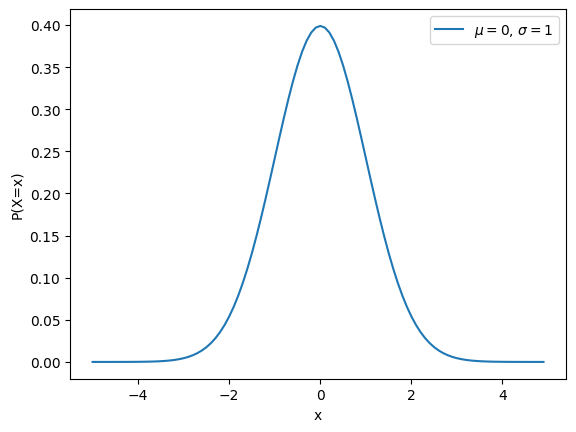

In [181]:
xs = np.arange(-5, 5, 0.1)  # Define values of x
mu = 0
sigma = 1

# Compute the probability of each value of x:
pdf = [normal_pdf(x, mu, sigma) for x in xs]

fig, ax = plt.subplots()
ax.plot(xs, pdf, label=f'$\\mu=0$, $\\sigma=1$')
ax.set_ylabel('P(X=x)')
ax.set_xlabel('x')
ax.legend()
plt.show()
plt.close()

The shape of the curve is familiar, it looks like the beta distribution we used before as our prior, except the beta distribution was limited to values between 0 and 1. In this case, there is no limits. When you think about it, it kinds of make sense. In the model above, the use of a normal distribution is basically saying 'it is most likely that the error of our model is small'. The flipper weight of the penguin isn't expected to fall exactly on the regression line, because that would entail that penguins weight is fully determined by their flipper length. But at the same time, it probably isn't very likely to have a penguin with flipper length 170mm that weight 200 kg. Provided that we have fitted a linear model to our data and that there is a linear relationship between the two variables of interest, values that are far away from our predictions are less likely than values close around it. 

Now of course, all of this is relative. For some cases, you may have very tight correlation between the two variables, which would mean that the independent variable (x) is one of the main factor determining your dependent variable (y), in which case you may have a small error. But in other cases, you may have a not so tight correlation, meaning that while the two variables of interest might be related to one another, there may be a lot of error remaining. One important thing to understand when it comes to linear model is that the strength of the $\beta$ alone doesn't tell you anything about the strength of the association between your two variables. You may have two variables that are very strongly associated but with a small $\beta$, or you may have variables that are not so strongly associated but have high better. 

And as you can see in the `linear_mdl` function and in the formulae of the normal distribution, there are two important parameters: $\mu$ and $\sigma$. The mean parameter $\mu$ specifies the middle of the distribution, and the spread parameter $\sigma$ controls the width of the distribution. We can illustrate it by plotting the same distribution with different parameters:

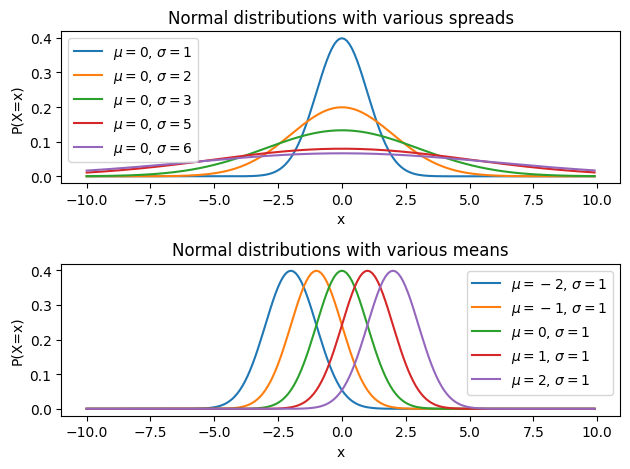

In [182]:
xs = np.arange(-10, 10, 0.1)  # Define values of x

fig, ax = plt.subplots(2)
ax.flatten()
for sig in [1, 2, 3, 5, 6]:
    ax[0].plot(xs, [normal_pdf(x, 0, sig) for x in xs], label=f'$\\mu=0$, $\\sigma={sig}$')
ax[0].set_ylabel('P(X=x)')
ax[0].set_xlabel('x')
ax[0].legend()
ax[0].set_title('Normal distributions with various spreads')
for mu in [-2, -1, 0, 1, 2]:
    ax[1].plot(xs, [normal_pdf(x, mu, 1) for x in xs], label=f'$\\mu={mu}$, $\\sigma=1$')
ax[1].set_ylabel('P(X=x)')
ax[1].set_xlabel('x')
ax[1].legend()
ax[1].set_title('Normal distributions with various means')
plt.tight_layout()
plt.show()
plt.close()

In the simulated data, we chose $\mu=0$ and $\sigma=2$. Importantly, in linear model, the mean of the error term should always be 0, which means that the error should oscillate around 0. This makes sense: even if your model doesn't capture the data really well, you would still expect the dots to be randomly distributed around your regression line. If all the dots were above the regression line, that would be strange and it would in fact indicate that something is very wrong with your model or with your data. We won't go into the why, but the one big assumption of linear model is that the error follows a normal distribution centered on zero.

On the other hand, the $\sigma$ parameter depends on your data: if your model captures the data really well, then the error should be on average closer to zero, which implies that probability of large errors is lower, which in turn implies that the error follows a normal distribution with a small $\sigma$. On the other hand, if you have a model that doesn't capture the data really well, then you'd expect the error to follow a normal distribution with a large error. We can illustrate all of that simply. First, let's look at the **empirical distribution** of the error of our model in the example above:

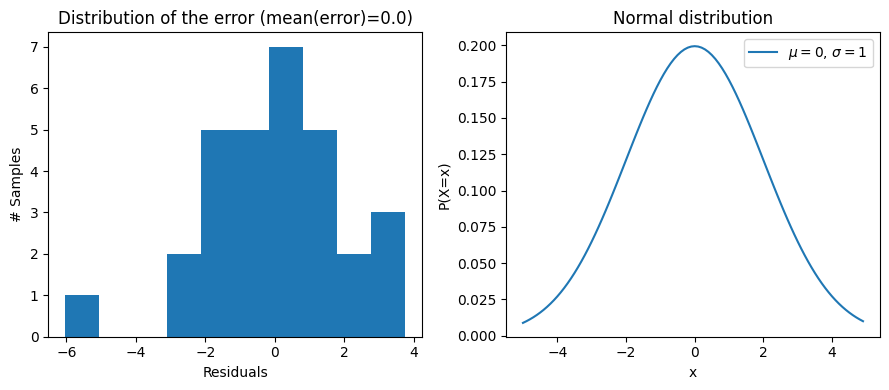

In [183]:
error = y - (beta_0 + beta_1 * flipper_length_mm)  # Calculate the error: the data - the predicted values (i.e. beta_0 + beta_1 x flipper length)

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].hist(error)
ax[0].set_xlabel('Residuals')
ax[0].set_ylabel('# Samples')
ax[0].set_title(f'Distribution of the error (mean(error)={np.round(np.mean(error), 2)})')

ax[1].plot(np.arange(-5, 5, 0.1), [normal_pdf(x, 0, 2) for x in np.arange(-5, 5, 0.1)], label=f'$\\mu=0$, $\\sigma=1$')
ax[1].set_ylabel('P(X=x)')
ax[1].set_xlabel('x')
ax[1].set_title('Normal distribution')
ax[1].legend()
plt.tight_layout()
plt.show()
plt.close()

We can see that indeed, the mean error is close to 0 and that the error values are between -5 and 5. And when you look at the normal distribution on the right, it looks possible that the error was sampled from such a distribution. They don't look exactly the same, but that's because the residuals are only a few samples. If we had many more obstractions, we would get the left to look closer to the right.

In the simulation, we chose a $\sigma=2$, which is completely arbitrary, just to illustrate the various points. We can easily simulate data with other parameters to illustrate what that would look like and the impact of sigma on the error:

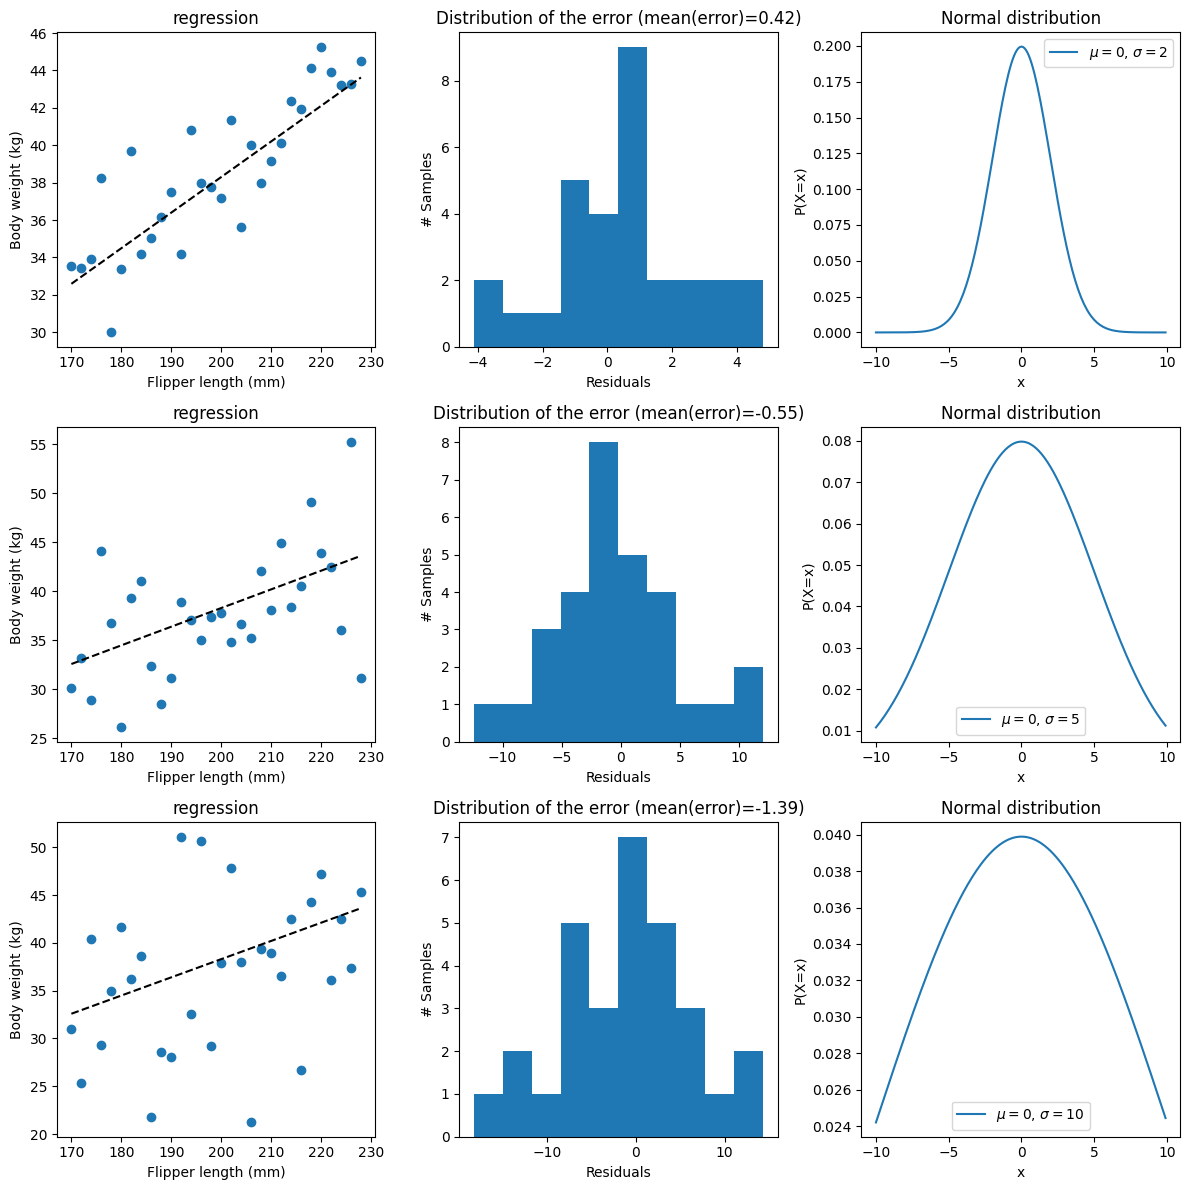

In [184]:
# Simulate the data with various noise levels:
sigmas = [2, 5, 10]
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, sigma in enumerate(sigmas):
    y = linear_mdl(flipper_length_mm, beta_0, beta_1, error_mu, sigma)
    error = y - (beta_0 + flipper_length_mm * beta_1)

    # Plot regression:
    ax[i, 0].scatter(flipper_length_mm, y)  # Plot the simulated data
    ax[i, 0].plot(flipper_length_mm, beta_0 + beta_1 * flipper_length_mm, color='k', linestyle='--', label='Regression line')  # Plot the regression line
    ax[i, 0].set_xlabel('Flipper length (mm)')
    ax[i, 0].set_ylabel('Body weight (kg)')
    ax[i, 0].set_title('regression')

    # Plot error:
    ax[i, 1].hist(error)
    ax[i, 1].set_xlabel('Residuals')
    ax[i, 1].set_ylabel('# Samples')
    ax[i, 1].set_title(f'Distribution of the error (mean(error)={np.round(np.mean(error), 2)})')

    # Plot the true error distribution:
    ax[i, 2].plot(np.arange(-10, 10, 0.1), [normal_pdf(x, 0, sigma) for x in np.arange(-10, 10, 0.1)], label=f'$\\mu=0$, $\\sigma={sigma}$')
    ax[i, 2].set_ylabel('P(X=x)')
    ax[i, 2].set_xlabel('x')
    ax[i, 2].set_title('Normal distribution')
    ax[i, 2].legend()
plt.tight_layout()
plt.show()
plt.close()

As expected, the larger the sigma, the more spread and the more 'noisy' the data are.

So hopefully, we this you should understand each bit of the linear model. We can now move on to the Bayes theorem part to try and get the probability of the parameters given the (simulated) data

## Bayes theorem applied to the linear model
As a reminder, the Bayes theorem is this:

$$P(\Theta|y) = \frac{P(y|\Theta)P(\Theta)}{P(y)}$$

Where:
- $P(y|\Theta)$: Likelihood, probability of the data given the parameters
- $P(\Theta)$: prior, probability of the parameter based on previous knowledge, i.e. what we believe the most likely values for the parameters are
- $P(y)$: marginal likelihood or model evidence, probability of y after marginalizing out all possible values of $\Theta$
- $P(\Theta|y)$: posterior, probability of the values for the parameters given the data we have seen

A few things might be confusing at first. In the previous example, we didn't really have a model: we flipped a coin many times, counted how often we got head. We determined that the likelihood for this model is the binomial distribution that tells us what the probability of each value $\Theta$ (i.e. P(X=1)) is. We didn't need a model, so why do we need one now? That's because in the coin tossing model, the parameter of interest was directly observable. If our question was 'What is the average weight of a penguin?', we also wouldn't need a model, we would simply way many penguins (just like we through the coin many times to estimate the true probability of getting head) and use the Bayes theorem to establish how confident we are in the true weight of the penguin being what we measured, given our observations. However, our current question is a little bit more complicated: we want to know how two different variables relate to one another. This isn't something we can directly observe, so we need the model and so basic math to 'extract' that parameter from the data. To the risk of being overly abstract, we can say that in the case of the coin toss example (or if we want to know the average weight of a penguin), there is in fact a model. This model is a bit 'hidden' and we would say that it is implicit. That implicit model is that each coin toss is an independent Bernoulli trial with probability of success $\Theta$ (don't worry if that doesn't make perfect sense to you, it is not that critical to understand). 

The key message is that the Bayes theorem is agnostic as to what the paramater you are trying to estimate is, and whether it can be directly estimated (i.e. take the number of head out of your number of throw or weight many penguins) or not. It is simply a way to relate the probability of your data given any values of your parameters to the probability of the true value of these parameters given the data (based on the prior and marginal likelihood of course). So it would work for any models you can think off that may give rise to the data you are interested in. We will see below how that works for our simple linear model, and hopefully that should make it clear how it could work in principle for other kind of models.

But before we get started, you might wonder about another difference from the previous examples. In the coin toss example, there was only one parameter we were interested in ($P(X=1)$). But in the linear model, there are two parameters: $\beta_0$ and $\beta_1$. In fact, as you will see below, there are also other parameters we will try to estimate which relate to the error. However, in the formulation of the Bayes theorem we have seen so far, there was a single term for $\Theta$. However, that doesn't need to be the case. $\Theta$ is a general term that can refer to one, but also many parameters. So in our example, you can say something like this:

$$P(\Theta|y) = \frac{P(y|\Theta)P(\Theta)}{P(y)}$$

where:

$$\Theta=\beta, \sigma^2$$

Or you could rewrite the Bayes theorem direclty like this:

$$P(\beta, \sigma^2|y) = \frac{P(y|\beta, \sigma^2)P(\beta, \sigma^2)}{P(y)}$$

That's also fine.

So with all of that out of the way, we can now attack the Bayesian problem. As in the previous example, we need to figure out what the likelihood function of this particular model, then what our priors should be, and finally try to integrate over the product of these two things to get the model evidence.

### The linear model in vector form
One last thing before we get started though. The expression we have used for the linear model above is only one way to write it down. There is another way that is a bit more convenient, but requires a bit of knowledge and skill in matrix algebra. Previously, we wrote the model as:

$$y = \beta_0 + \beta_1x + \epsilon$$

where:
- $y$: the data (weight of the penguin)
- $\beta_0$: the intercept parameter, to be estimated (weight of a penguin with flipper length 0 according to our model)
- $\beta_1$: regression coefficient between $y$ and $x$, to be estimated (for each unit increase in flipper length, what is the change in body weight)
- $x$: regressor, fixed, i.e. this will not be estimated by our model (flipper length of each penguin)
- $\epsilon$: error, whatever isn't captured by our model, to be estimated (difference between the actual body weight of our penguin and what our model expected)

Note that for our problem, there is only one $x$, but generally speaking, we would call it $x_1$, because there may be several regressor. For example, after you ran your model to look at the weight of penguin as a function of their flipper length, you might realize that actually, a better model would also take into account the size of their feet, so you could add another regressor with its own beta $\beta_2x_2$ referring to the feet sizes. One way to vizualize the model is this:

|penguins | y (body weight)  = | $\beta_0$ * | $x_0$ + | $\beta_1$ * | $x_1$ (flipper length) + | $\epsilon$ |
| -------- | ------- | -------- | ------- | -------- | ------- | -------- | 
|penguin 1|  62kg  |  ???? | 1 | ????| 170 | ????|
|penguin 2|  70kg  |   | 1 | | 175 | ????|
|penguin 3|  66kg  |   | 1 | | 180 | ????|
|penguin 4|  72kg  |   | 1 | | 185 | ????|

We have the body weight of each penguin, as well as their flipper lengths, and we try to figure out what is the one value we can multiply their flipper length with to get their body weight by. Note that I have added $x_0$ for the intercept, this is only 1, because the intercept is a constant to this model. So if $\beta_0=0.5$, that just makes sure that we add 0.5 to the body weight of every single penguin. Note that if we have many $x$ and $\beta$, the final results would just be the sum of all of that plus some error.

We can rewrite the linear model as such:

$$y =  X\Beta + \epsilon$$

This is exactly the same thing, except this time, xs and betas are matrices. So in other words, we have:
$$
\begin{bmatrix}
y_1\\
y_2\\
y_3\\
y_4\\
\end{bmatrix}
=


\begin{bmatrix}
1 & x_{1, 1}\\
1 & x_{1, 2}\\
1 & x_{1, 3}\\
1 & x_{1, 4}\\
\end{bmatrix}
\times
\begin{bmatrix}
\beta_0\\
\beta_1
\end{bmatrix}

+

\begin{bmatrix}
\epsilon_1\\
\epsilon_2\\
\epsilon_3\\
\epsilon_4\\
\end{bmatrix}

$$

If you aren't familiar with matrix operations, that might not be terribly obvious. But in matrix algebra, there a few specific rule about how you are supposed to muliply and combine matrices together. In our specific case, when you have:

$$
\begin{bmatrix}
1 & x_{1, 1}\\
1 & x_{1, 2}\\
1 & x_{1, 3}\\
1 & x_{1, 4}\\
\end{bmatrix}
\times
\begin{bmatrix}
\beta_0\\
\beta_1
\end{bmatrix}
$$

what you have to do is multiply the first column of the $X$ matrix by $\beta_0$, then the second column of the $X$ matrix by $\beta_1$ and then take the sum of the two column. So that's basically the exact same thing as we did before. It's just a more compact notation, especially because if you have many regressors, the same formulae:

$$y =  X\Beta + \epsilon$$

Only this time you have more columns in your $X$ matrix, and as many $\Beta$ as you have columns in x. Don't worry too much if that's a bit confusing, it's really just a question of notation, and you can always stick to the more 'classical notation' if that's what you prefer. In what follows, I will always provide both notations to make it easier. 

### The likelihood of the estimated parameters of a linear model:

The first need we need is a function for the likelihood of the data under given parameters. That's the same concept as before, but it is a little bit more complicated, for several reasons. The first reason is that compared to our coin toss example where the probability of observing a given number of heads depended on a single parameter of interest (the probability of getting head), in our current problem we have several parameters: $\beta_0$, $\beta_1$ (but also the error term). Accordingly, we need a likelihood function that tells us the probability of observing a given outcome $y_i$ given the value of several parameters. In addition, compared to the previous example where the data were a single observation $y$ (the number of head we observed in our experiment), in the current case we have many observations $y_i$ (one per penguin). We will see how to deal with these two complications one by one before putting everything together. 

#### The likelihood of one observation
The first need we need is a function for the likelihood of the data under given parameters. It's easy to get confused at this point, so let's clarify. In Bayesian inference, the likelihood is the probability of observing the data given particular values of the parameters. It answers questions like:

- "If $\beta_0=0$ and $\beta_1=0.21$, what is the probability of observing a penguin with flipper length 190mm that weight 70 kg?"

Importantly, the likleihood is a probability density function, which is a function that can answer that question for any values of $\beta_0$ and $\beta_1$. 

Before you continue reading, try to think about what that could look like. 

An intuition you might have is that values of $yi$​ close to the prediction of your model should be more likely. Indeed, if you examine the error distribution histogram from earlier, you'll notice there are fewer penguins with large errors and more with smaller errors. Formally, this suggests that the likelihood of observing the data given certain parameters $\beta_0$ and $\beta_1$​ is higher when the observed data are close to the model's predictions.

Now, if you tried to look at the likelihood of the data separately for each parameter, you might expect to see something resembling a normal distribution: the data close to the expected value should be most likely, and the likelihood should decrease as you move further away. However, you cannot look at the likelihood of the data for each parameter separately; you need to consider them together. This is because the probability of observing a given data point $y_i$​ depends on both $\beta_0$​ and $\beta_1$​ simultaneously.

To proceed, it would be helpful to know the form of the distribution that represents the likelihood of observing a given data point given these parameters. We can achieve this by making an assumption about the error term $\epsilon$​ to ensure that the likelihood function is normally distributed.

Once again, our model is defined as:

$$y_i = \beta_0 + \beta_1 x_i + \epsilon$$

So our data y_i is basically a constant ($beta_0$), plus a constant ($beta_1$) multiplied by so fixed values (flipper length, $x_i$), plus the error term. As we already mentioned, one assumption of the linear model is that the $\epsilon$ is normally distributed around 0, so it is a normal distribution. This is stated as such:

$$\epsilon \sim \mathcal{N}(0, \sigma^2)$$

Which means that the error follows a normal distribution centered on 0 and with standard deviation $\sigma$. Actually, the very reason behind the assumption that the error should be normally distributed is so that the likelihood function also follows a normal distribution. If that's not the case, everything breaks. 


**So what's the formula for the likelihood of a single observation $y_i$ given the parameters? $P(y_i|\beta_0, \beta_1, \sigma^2)$**

We won't be able to go into the why here (perhaps we will write a separate chapter about it at some point), but the answer is this:

$$P(y_i|\beta_0, \beta_1, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp{-\frac{(y_i-(\beta_0 + \beta_1*x_i))^2}{2\sigma^2}}$$

If you remember the normal distribution formulae from above, it's basically the same, except we replaced the $\mu$ term by: $\beta_0 + \beta_1*x_i$. This kind of makes sense when you think about it: the mean value in the case of a linear regression is the value predicted by the model. This is called the **expected value**. If you have your observation $y_i$ very far away from your model, then $(y_i-(\beta_0 + \beta_1*x_i))^2$ increases, and because you have a minus in front, the exponent yields a smaller result. And so the further away your observation is from your model predicted value ($\beta_0 + \beta_1*x_i$), the more the likelihood decreases.

Let's write some code to illustrate this function. We will first simulate some data then use the optimal least square method to retrive the fitted values of $\beta_0$ and $\beta_1$. Then, we will compute the error of each single point to find the data point which has the smallest error, and the one that has the largest error. Again, the likelihood function give us the likelihood of the observation given any values of the parameters. And we saw that the probability of observing the data should be concentrated around the values of $\beta_0$ and $\beta_1$ that result in prediction that are closest to that observation

In [185]:
def single_obs_likelihood(yi, xi, b0, b1, sigma):
    """
    Computes the likelihood of observing yi given xi for parameters b0, b1, and sigma.
    """
    # Compute square of the error
    sq_err = (yi - (b0 + b1 * xi))**2
    # Compute normalization constant
    norm_k = 1/np.sqrt(2*np.pi*sigma**2)

    # Compute hte likelihood
    return norm_k * np.exp(-(sq_err/(2*sigma**2))) 

# Set the parameters:
beta_0_gt = 0
beta_1_gt = 0.22
error_mu = 0
error_sigma = 2

# Simulate some data:
y = linear_mdl(flipper_length_mm, beta_0_gt, beta_1_gt, error_mu, error_sigma)

# Fit the model:
beta_0, beta_1 = fit_linear_model(y, flipper_length_mm)
print(f'Estimated beta_1={np.round(beta_1, 3)}')
print(f'Estimated beta_0={np.round(beta_0, 3)}')

# Compute the error:
err = y - (beta_0 + beta_1 * flipper_length_mm)

# Find the minimal error:
min_error = err[np.argmin(err**2)]
predicted_val = beta_0 + beta_1 * flipper_length_mm[np.argmin(err**2)]
observed_val = y[np.argmin(err**2)]
print("-"*40)
print(f"The smallest error is of {min_error} kg")
print(f"The model predicted {predicted_val} kg")
print(f"The observed weigth is {observed_val} kg")

Estimated beta_1=0.235
Estimated beta_0=-2.824
----------------------------------------
The smallest error is of -0.06998306028700085 kg
The model predicted 50.22231318570947 kg
The observed weigth is 50.152330125422466 kg


Computing the likelihood of y=50.152330125422466 for the penguin with flipper length=226


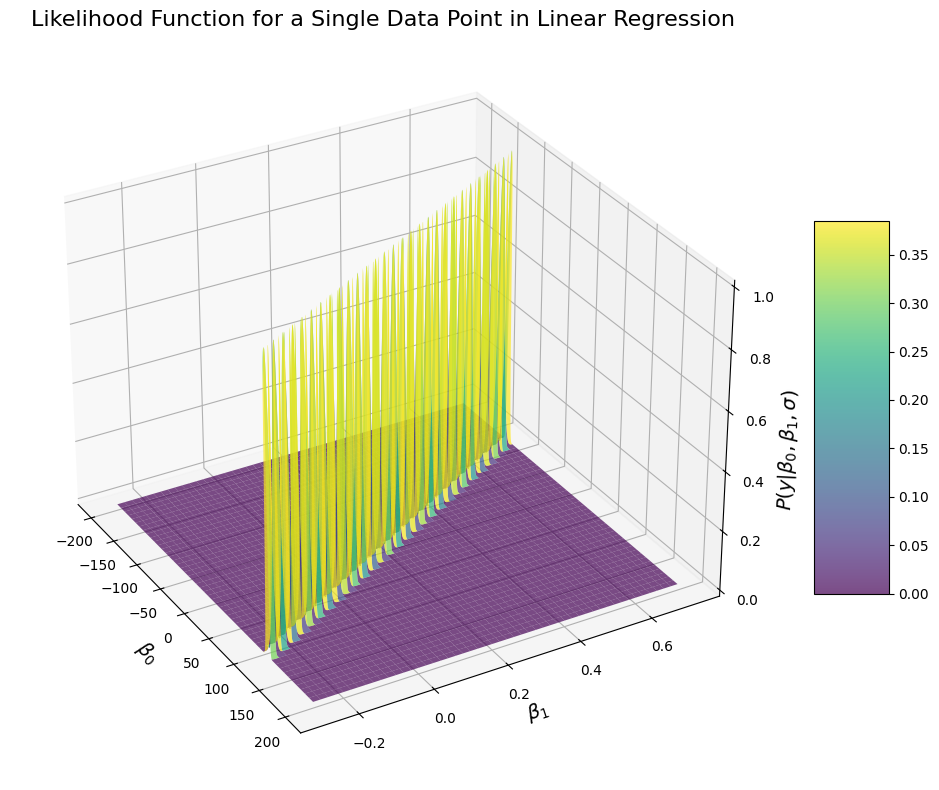

In [186]:
from matplotlib import cm

# Plot the probability of each observation across several values of b0 and b1:
b0s = np.linspace(beta_0_gt -200, beta_0_gt + 200, 1000)
b1s = np.linspace(beta_1_gt - 0.5, beta_1_gt + 0.5, 1000)
B0s, B1s  = np.meshgrid(b0s, b1s)

# Compute the likelihood for the value with the smallest error:
print(f"Computing the likelihood of y={y[np.argmin(err**2)]} for the penguin with flipper length={flipper_length_mm[np.argmin(err**2)]}")
likelihood = single_obs_likelihood(y[np.argmin(err**2)], flipper_length_mm[np.argmin(err**2)], B0s, B1s, error_sigma)
# Normalize by max to improve viz
likelihood /= np.max(likelihood)
# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(B0s, B1s, likelihood, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.7)
# Customize the axes
ax.set_xlabel(r'$\beta_0$', fontsize=14)
ax.set_ylabel(r'$\beta_1$', fontsize=14)
ax.set_zlabel(r'$P(y|\beta_0, \beta_1, \sigma)$', fontsize=14)
ax.set_title('Likelihood Function for a Single Data Point in Linear Regression', fontsize=16)
# Adjust viewing angle for better visualization
ax.view_init(elev=30, azim=-30)
# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()



This probably doesn't look like what you'd have expected (at least it doesn't look like what I would have expected). The results look like there is a ridge along which the probability of the data is very high, and everyhing outside of it is very low. This shape is however to be expected. This is because with a single data point, there isn't enough data to determine the likelihood of the data given the parameter. In the current example, we are looking at the likelihood of observing a penguin weighting 43.85Kg with flipper size of 196mm, given the values of $\beta_0$ and $\beta_1$ and our model $y = \beta_0 + \beta_1 * x$. But of course, there are many possible values of $\beta_0$ and $\beta_1$ that can yield 43.85:

$$\beta_0 + \beta_1 * 196 = 43.85$$

There is an infinity of solution:

If we fix $\beta_0$ at 1, then: 

$$\beta_1 = (43.85 - 1) / 196$$

This is why the probability density function of observing a given value given any value of $\beta_0$ and $beta_1$ does not have a single peak, because there are many configuration of parameters under which the data are equally likely. 

This may seem confusing, but don't worry if you don't understand everything, it's difficult to get good intuition for these things. What matters is that we have the formulae to get the likelihood of a single observation. So now we can tackle the second complication to get the likelihood for our model

#### The likelihood of several observation
Now that we know the likelihood for a single observation, we can try and understand how we can deal with many observation. Indeed, for our current model, we want to know not only the likelihood of observing a value $y_i$ but rather the likelihood of observing all the data $y$ (all the penguins with their flipper length and weights) given the parameters. For this, we need to call upon an additional assumption of a linear model: the data should be independently and identically distributed, which relates ot our previous assumption about the normal distribution of the error. What that means is that we need to assume that each observation is independent from each other. If that is the case (which it should always be if you are running a linear model), then the likelihood of observing all data point is the product of the likelihood of each data point:

$$P(y|\beta_0, \beta_1, \sigma) = P(y_1|\beta_0, \beta_1, \sigma) * P(y_2|\beta_0, \beta_1, \sigma) * ... P(y_n|\beta_0, \beta_1, \sigma)$$

Where $n$ is the number of observations (i.e. the number of penguins). You can rewrite the expression above like so:

$$P(y|\beta_0, \beta_1, \sigma) = \prod_{i=1}^{n} P(y_i|\beta_0, \beta_1, \sigma)$$

The symbol $\prod$ means multiplication from $i \to n$, similar to the $\sum$ operator.

And so if we replace $P(y_i|\beta_0, \beta_1, \sigma)$ with the formulae we had before, we get the following:

$$P(y|\beta_0, \beta_1, \sigma) = \prod_{i=1}^{n}[\frac{1}{\sqrt{2\pi\sigma^2}} exp^{-\frac{[y_i-(\beta_0 + \beta_1x_i)]^2}{2\sigma^2}}]$$

We can simplify this formulae a little, just as we did in the previous chapter. The term $\frac{1}{\sqrt{2\pi\sigma^2}}$ doesn't depend on $\beta_0$ nor on $\beta_1$, sp we can take it out:

$$P(y|\beta_0, \beta_1, \sigma) = (\frac{1}{\sqrt{2\pi\sigma^2}})^n\prod_{i=1}^{n}exp^{-\frac{[y_i-(\beta_0 + \beta_1x_i)]^2}{2\sigma^2}}$$

So again, not a crazy complicated formulae. We can implement it programmatically and then see what the likelihood of our data will look like:

In [187]:
def lm_likelihood(y, x, b0, b1, sigma):
    """
    Computes the likelihood of observing y given x for parameters b0, b1, and sigma.
    
        Parameters:
        - y : array-like, observed values
        - x : array-like, predictor values
        - b0 : float, intercept parameter
        - b1 : float, slope parameter
        - sigma : float, standard deviation of the error term
        
        Returns:
        - likelihood : float, the likelihood of the observed data given the parameters
    """
    # Check number of observations:
    n = y.shape[0]

    # Calculate the predicted values using the linear model
    y_pred = b0 + b1 * x

    # Compute the squared residuals (y - y_pred)^2
    squared_residuals = (y - y_pred) ** 2

    # Calculate the likelihood for each observation
    norm_const = (1 / np.sqrt(2 * np.pi * sigma**2))**n

    # Product of each likelihood:
    likelihoods_prod = np.prod(np.exp(-(squared_residuals/(2*sigma**2))))

    return norm_const * likelihoods_prod

Now that we have implemented the function for the likelihood, we can try plot the likelihood of our observation given various values of b0 and b1. We will do the same as before: simulate data (so that we know the ground truth), then compute the likelihood of our data given a range of $\beta_0$ and $\beta_1$:

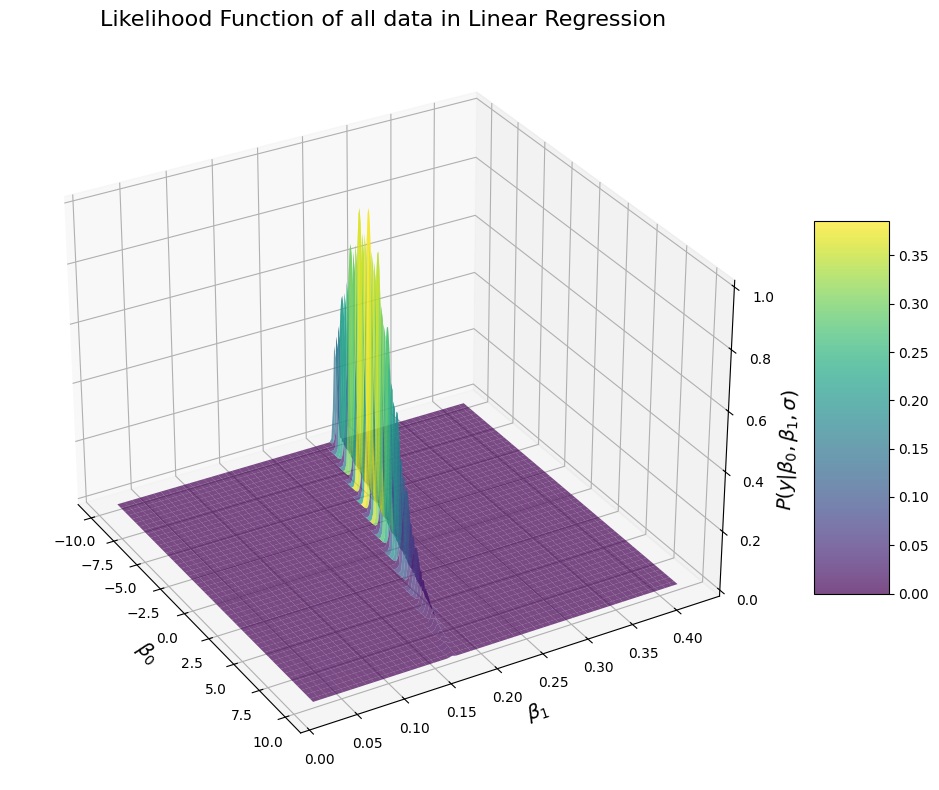

In [188]:
# Set the parameters:
beta_0_gt = 0
beta_1_gt = 0.22
error_mu = 0
error_sigma = 2

# Simulate some data:
y = linear_mdl(flipper_length_mm, beta_0_gt, beta_1_gt, error_mu, error_sigma)

# Plot the probability of each observation across several values of b0 and b1:
b0s = np.linspace(beta_0_gt -10, beta_0_gt + 10, 200)
b1s = np.linspace(beta_1_gt - 0.2, beta_1_gt + 0.2, 200)
B0s, B1s  = np.meshgrid(b0s, b1s)
y_likelihood = np.zeros(B0s.shape)
for i, b0 in enumerate(b0s):
    for ii, b1 in enumerate(b1s):
        y_likelihood[ii, i] = lm_likelihood(y, flipper_length_mm, b0, b1, error_sigma)
# Normalize by max to improve viz
y_likelihood /= np.max(y_likelihood)
# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(B0s, B1s, y_likelihood, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.7)
# Customize the axes
ax.set_xlabel(r'$\beta_0$', fontsize=14)
ax.set_ylabel(r'$\beta_1$', fontsize=14)
ax.set_zlabel(r'$P(y|\beta_0, \beta_1, \sigma)$', fontsize=14)
ax.set_title('Likelihood Function of all data in Linear Regression', fontsize=16)
# Adjust viewing angle for better visualization
ax.view_init(elev=30, azim=-30)
# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

Hm, okay, that doesn't look quite like what you may have expected. Let's think about it for a sec. The likelihood is once again very elongated, which means that there is some sort of a correlation between $\beta_0$ and $beta_1$ in terms of likelihood. Indeed, the observed data are more likely for particular values of $\beta_0$ and $beta_1$, but the pairs of values of $\beta_0$ and $beta_1$ for which the data are most likely clearly follow a line. Why is that? There is actually a very good reason. It's because the different values of $beta_1$, you can adjust the intercept $\beta_0$ to make them fit the data better. Or the other way around, you can offset changes in the intercept by changing the slope to make the data fit better. Here is a vizualization for why that's the case

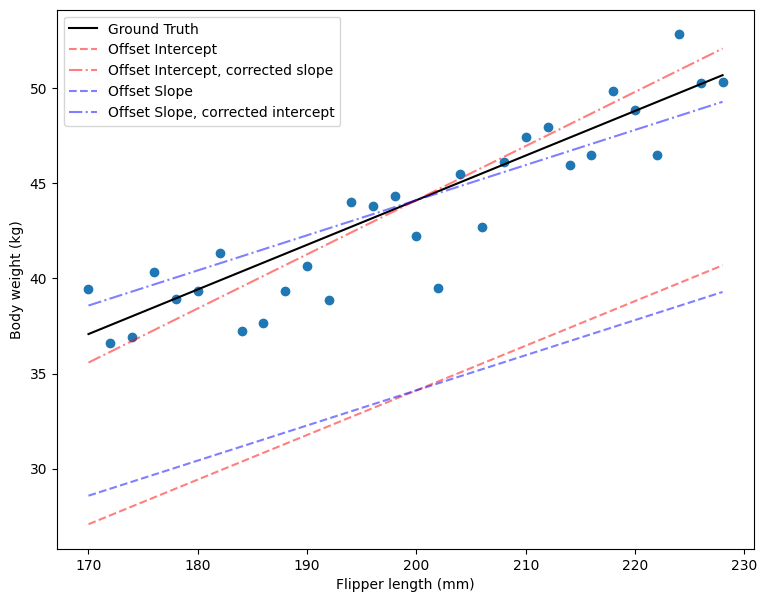

In [189]:
# Plot the data:
fig, ax = plt.subplots(figsize=(9, 7))
ax.scatter(flipper_length_mm, y)  # Plot the simulated data
ax.plot(flipper_length_mm, beta_0 + beta_1 * flipper_length_mm, color='k', linestyle='-', label='Ground Truth')  # Plot the regression line
ax.plot(flipper_length_mm, beta_0-10 + beta_1 * flipper_length_mm, alpha=0.5, color='r', linestyle='--', label='Offset Intercept')  # Plot the regression line
ax.plot(flipper_length_mm, beta_0-10 + (0.05+beta_1) * flipper_length_mm, alpha=0.5, color='r', linestyle='-.', label='Offset Intercept, corrected slope')  # Plot the regression line
ax.plot(flipper_length_mm, beta_0 + (-0.05+beta_1) * flipper_length_mm, alpha=0.5, color='b', linestyle='--', label='Offset Slope')  # Plot the regression line
ax.plot(flipper_length_mm, beta_0 + 10 + (-0.05+beta_1) * flipper_length_mm, alpha=0.5, color='b', linestyle='-.', label='Offset Slope, corrected intercept')  # Plot the regression line
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body weight (kg)')
ax.legend()
plt.show()
plt.close()

You can see in the plot above that when the intercept parameter $\beta_0$ is far from its ground truth value (as indicated by the red lines), you can still obtain a line that closely approximates the true relationship by adjusting the slope parameter $\beta_1$. Similarly, if β1β1​ deviates from its true value (as shown by the blue lines), adjusting $\beta_0$ can compensate for this discrepancy, resulting in a line that aligns well with the observed data. This illustrates why there is a correlation between $\beta_0$ and $\beta_1$ in the likelihood function: there are multiple pairs of $\beta_0$ and $\beta_1$ that yield similar fits to the data. Adjusting one parameter can offset changes in the other, allowing the model to maintain a good approximation of the true relationship.

If you recall the formula for the likelihood function, the likelihood is higher when the squared error term $[y_i-(\beta_0 + \beta_1x_i)]^2$ is minimized. This means that parameter values producing predictions close to the actual observations result in a larger likelihood. Therefore, combinations of $\beta_0$ and $\beta_1$ that minimize this error term will make the data more probable under the model.

In other words, the data are most likely under parameters where the predicted values are least different from the actual observations. Because there are multiple pairs of $\beta_0$ and $\beta_1$ (not just the ground truth values) that can produce predictions close to the observed data—and because adjustments in one parameter can be compensated by changes in the other—we observe this elongated shape in the likelihood surface.

Whenever you see an elongated shape like this in a likelihood plot, it indicates that the two variables on the axes—in our case, $\beta_0$ and $\beta_1$-are correlated. It's important to clearly understand what we mean by this correlation, so I will repeat it one last time: it means that the likelihood of the data remains high for certain combinations of $\beta_0$ and $\beta_1$, and that changing one parameter can be offset by adjusting the other to maintain a similar level of fit to the data.

Now you might think that in our current example, it is what it is: $\beta_0$ and $\beta_1$ are correlated in terms of likelihood. It is after all true that in what we saw above, there are specific pairs of $\beta_0$ and $\beta_1$ that yield a line that is a good approximation of the data, and simply because of how our model is constructed, these values of $\beta_0$ and $\beta_1$ are correlated: if we increase $\beta_0$, we can salvage it by reducing $\beta_1$ and the other way around. Why would we want to do anything about it, if it is just the way it is? Well actually, we do want to do something about it, because as we will see below, it is a bit of a problem. In short, there are several related issues posed by this correlation: 
- the estimates may become unreliable, because it makes it more likely when you are dealing with real data that the parameters you retrieve with the OLS method are off, because you get a wrong $\beta_0$ and its compensatory $\beta_1$ or the other way around
- it increases the domain of $\beta_0$ and $\beta_1$ under which the data are likely, which impacts the computation of the $\sigma$ parameter as we will see in a bit.

And as it turns out, there is actually a simple way in which we can deal with this issue: centering $x$, meaning you subtract the mean flipper length from each penguin flipper length. This results in the mean of the centered $x$ to be 0 instead of the actual mean value. That way, changed in $\beta_0$ represents the mean of the data and $beta_1$ the slope of the correlation between flipper length and weight, and $beta_0$ and $beta_1$ become independent. This is why it is always a good idea to center your predictors. We can see what that looks like:

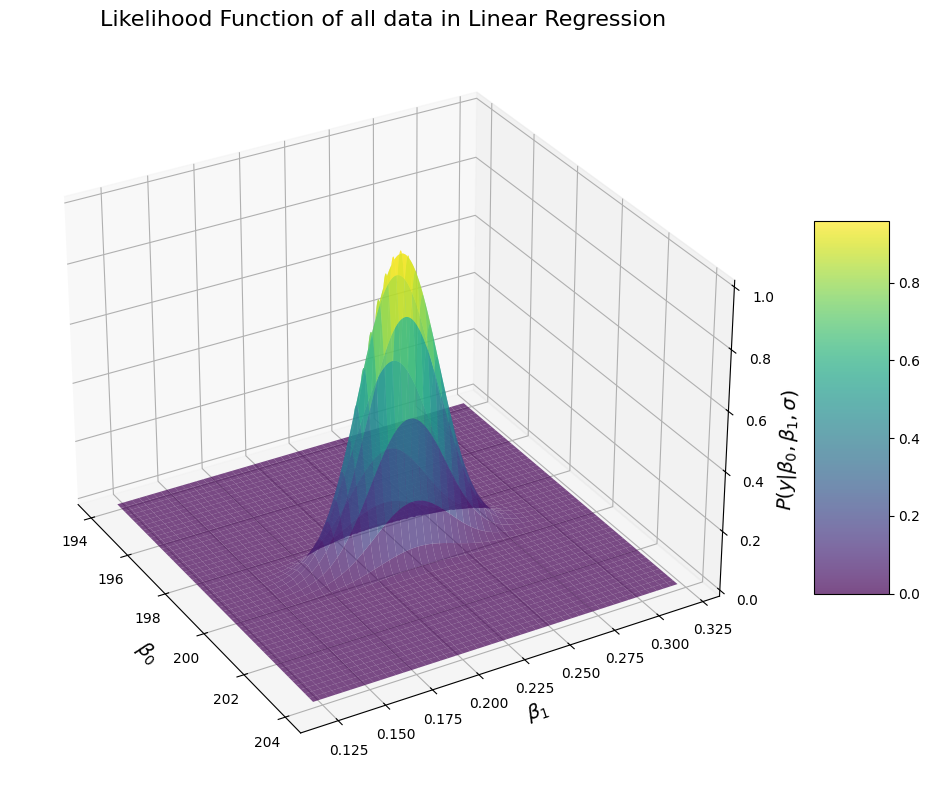

In [190]:
# Set the parameters:
beta_0_gt = np.mean(flipper_length_mm)
beta_1_gt = 0.22
error_mu = 0
error_sigma = 2

x_centered = flipper_length_mm - beta_0_gt
# Simulate some data:
y = linear_mdl(x_centered, beta_0_gt, beta_1_gt, error_mu, error_sigma)

# Plot the probability of each observation across several values of b0 and b1:
b0s = np.linspace(beta_0_gt -5, beta_0_gt + 5, 1000)
b1s = np.linspace(beta_1_gt - 0.1, beta_1_gt + 0.1, 1000)
B0s, B1s  = np.meshgrid(b0s, b1s)
y_likelihood = np.zeros(B0s.shape)
for i, b0 in enumerate(b0s):
    for ii, b1 in enumerate(b1s):
        y_likelihood[ii, i] = lm_likelihood(y, x_centered, b0, b1, error_sigma)
# Normalize by max to improve viz
y_likelihood /= np.max(y_likelihood) 
# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(B0s, B1s, y_likelihood, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.7)
# Customize the axes
ax.set_xlabel(r'$\beta_0$', fontsize=14)
ax.set_ylabel(r'$\beta_1$', fontsize=14)
ax.set_zlabel(r'$P(y|\beta_0, \beta_1, \sigma)$', fontsize=14)
ax.set_title('Likelihood Function of all data in Linear Regression', fontsize=16)
# Adjust viewing angle for better visualization
ax.view_init(elev=30, azim=-30)
# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()
plt.close()

Now that looks better: it is nice bell surface. This makes intuitive sense and is what we were expecting since the very beginning: the data are most likely around a given parameter of $\beta_0$ and $\beta_1$ (i.e. the peak of the bell) and they decrease when we go away from both $\beta_0$ and $\beta_1$ values in a way consistent with a normal distribution. Note that in order to generate this surface, we did not specify the fitted values of $\beta_0$ and $\beta_1$ from the optimal least square, nor the ground truth values of $\beta_0$ and $\beta_1$. Yet, the surface seems to be concentrated on a particular point that is close to what we would expect. We can find the parameters for which $\beta_0$ and $\beta_1$ the likelihood of our data is maximum:

In [191]:
print("The maximum likelihood of the data is observed at:")
print(f"b0={B0s[np.where(y_likelihood == np.max(y_likelihood))][0]:.2f}")
print(f"b1={B1s[np.where(y_likelihood == np.max(y_likelihood))][0]:.2f}")
print("The ground truth values are:")
print(f"b0={beta_0_gt:.2f}")
print(f"b1={beta_1_gt:.2f}")
print("Fitted values with OLS:")
print(f"b0={fit_linear_model(y, x_centered)[0]:.2f}")
print(f"b1={fit_linear_model(y, x_centered)[1]:.2f}")

The maximum likelihood of the data is observed at:
b0=199.37
b1=0.22
The ground truth values are:
b0=199.00
b1=0.22
Fitted values with OLS:
b0=199.36
b1=0.22


The likelihood of the data is maximal for values of $\beta_0$ and $\beta_1$ that are almost the same as what we obtain with the OLS method. Well in fact, they would be exactly the same if we were to sample the $\beta_0$ and $\beta_1$ more (i.e. if instead of taking a 1000 samples in the interval we took 10000 or more). This makes sense: the OLS finds the values of $\beta_0$ and $\beta_1$ that minimize the error, and the likelihood of observing the data is maximum for the parameters of  $\beta_0$ and $\beta_1$ that minimize the error. So you can think about it that way: the OLS finds the values of  $\beta_0$ and $\beta_1$ under which the data are the most likely, or that the OLS finds the peak of the likelihood. It's important to understand the distinction: the OLS returns single points, while the likelihood is a distribution. 

This brings us to another important term you may have come across: **Maximum Likelihood Estimates (MLE)**. The  $\beta_0$ and $\beta_1$ values you get with the OLS are the maximum likelihood estimates of these parameters, because well, they are the estimates for which the likelihood is maximum. So that also adds up.

So here it is, we have figured out the likelihood function for our linear model:

$$P(y|\beta_0, \beta_1, \sigma) = (\frac{1}{\sqrt{2\pi\sigma^2}})^n\prod_{i=1}^{n}exp^{-\frac{[y_i-(\beta_0 + \beta_1x_i)]^2}{2\sigma^2}}$$

and provided that the values of x are centered (i.e. there is no correlation between $\beta_0$ and $\beta_1$ anymore), the likelihood looks like a bell. There is one important thing we need to add for completeness' sake. In our example, we have only one regressor. But in a linear model, we can have many (in which case we have a multiple regression). The likelihood formulae remains almost the same, only we need to add the additional betas:

$$P(y|\beta_0, \beta_1, \sigma) = (\frac{1}{\sqrt{2\pi\sigma^2}})^n\prod_{i=1}^{n}exp^{-\frac{[y_i-(\sum_{k=0}^{m}{\beta_kx_k})]^2}{2\sigma^2}}$$

With $m$ regressors $k$

Now it becomes obvious why the matrix notation may become handy. The exponential term is a bit complicated and tough to read. We can reformulate the above like so:

$$P(y|\beta_0, \beta_1, \sigma) = (\frac{1}{\sqrt{2\pi\sigma^2}})^n\prod_{i=1}^{n}exp^{-\frac{[y_i-X\Beta]^2}{2\sigma^2}}$$

That's exactly the same thing, just a bit less clunky. 

#### The error term and estimation of the $\sigma$ parameter 

Unfortunately, we aren't done just yet... There is one thing we haven't talked about: what about the $\sigma$ parameter? So far, we have seen that the likelihood of the data can be determined for each pair of $\beta_0$ and $\beta_1$ values and that we can use the OLS formula to find the peak of the likelihood (the values of $\beta_0$ and $\beta_1$ under which the data are most likely), but we always kept $\sigma$ constant. And we always used the ground truth value of $\sigma$. Obviously, when we are dealing with actual data (rather than simulated ones), we don't know the true value of $\sigma$, i.e. we don't know what the true amount of variation around our predicted values (from our model) there is.  

But we everything you have learned so far, you might already know where this is going. You might in fact wonder: "what about $\sigma$?" As in, do we actually need to do anything about it? Well the answer is no. In the previous example, we simply set value of $\sigma$ to the ground truth just for conveniences' sake and because it is not possible to draw a graph with more than 3 dimensions. But since the beginning, $\sigma$ is an input to the likelihood function, which means that the likelihood function shows the likelihood of the data under any values of $\beta_0$ and $\beta_1$ but also $\sigma$. We can plot the likelihood function for different values of $\sigma$ to see what that looks like:

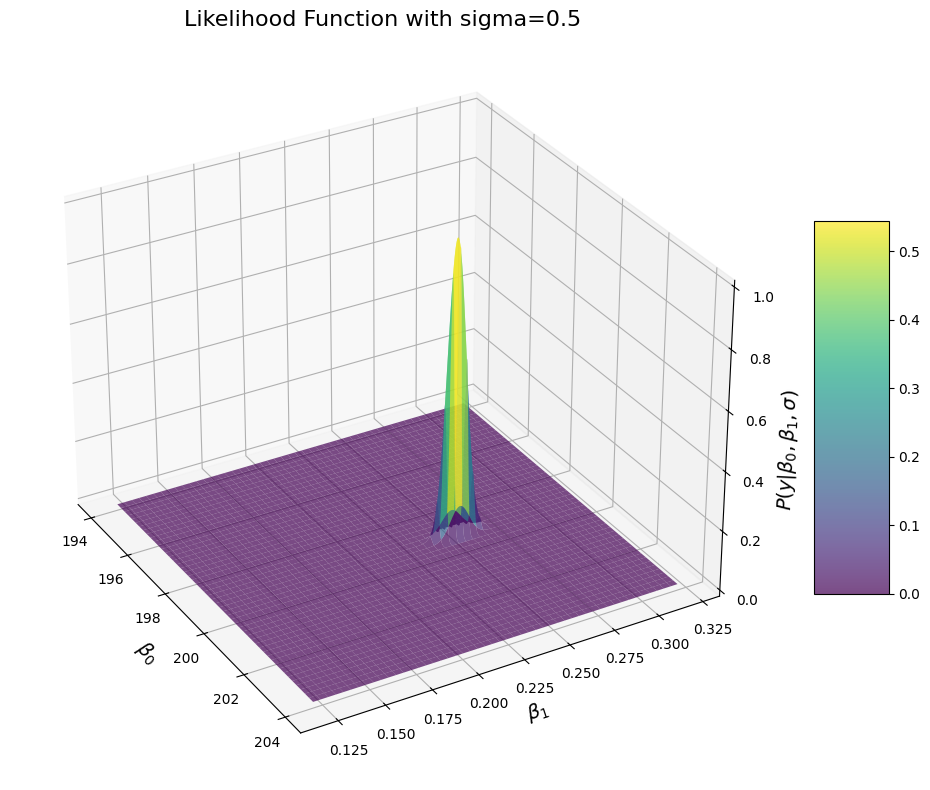

The maximum likelihood of the data is observed at:
b0=199.42
b1=0.25


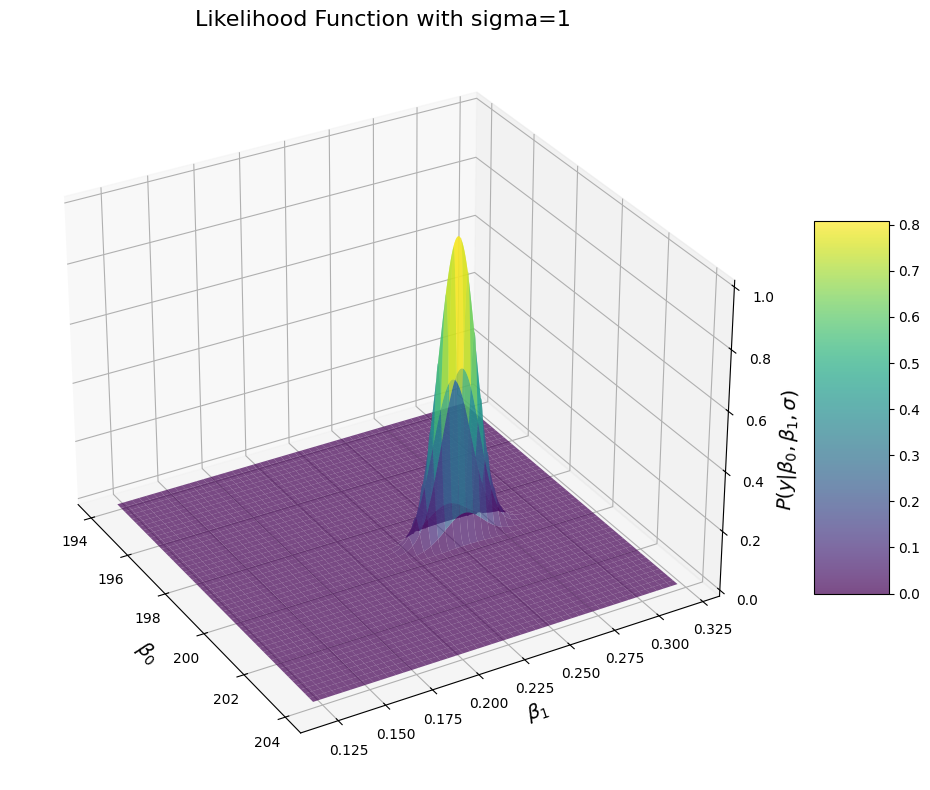

The maximum likelihood of the data is observed at:
b0=199.42
b1=0.25


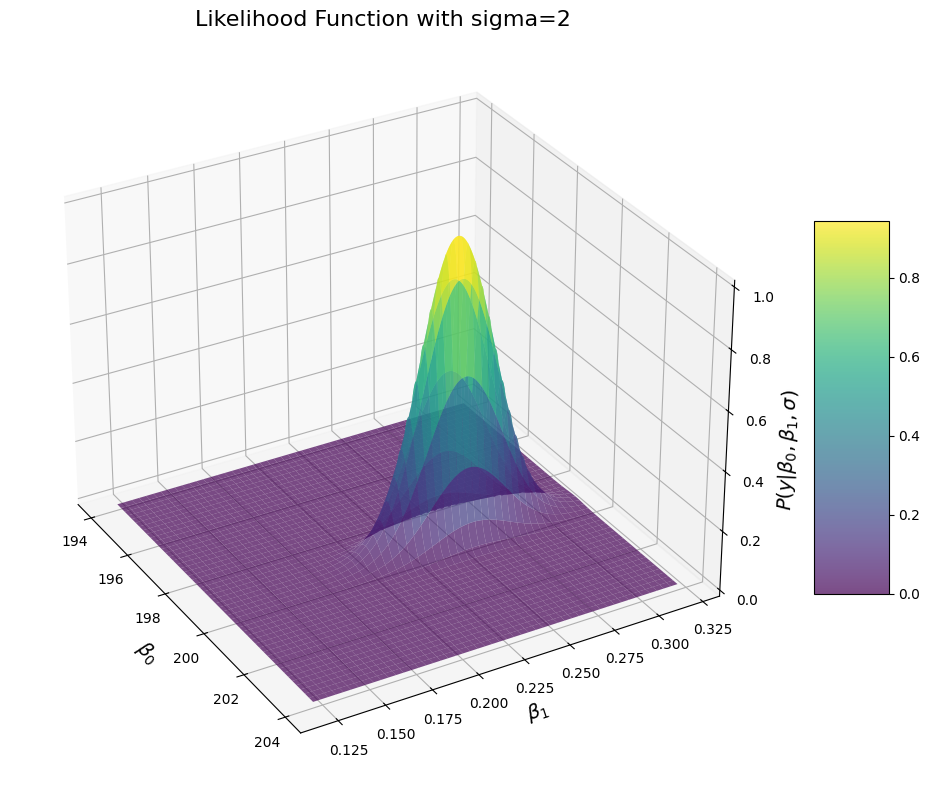

The maximum likelihood of the data is observed at:
b0=199.42
b1=0.25


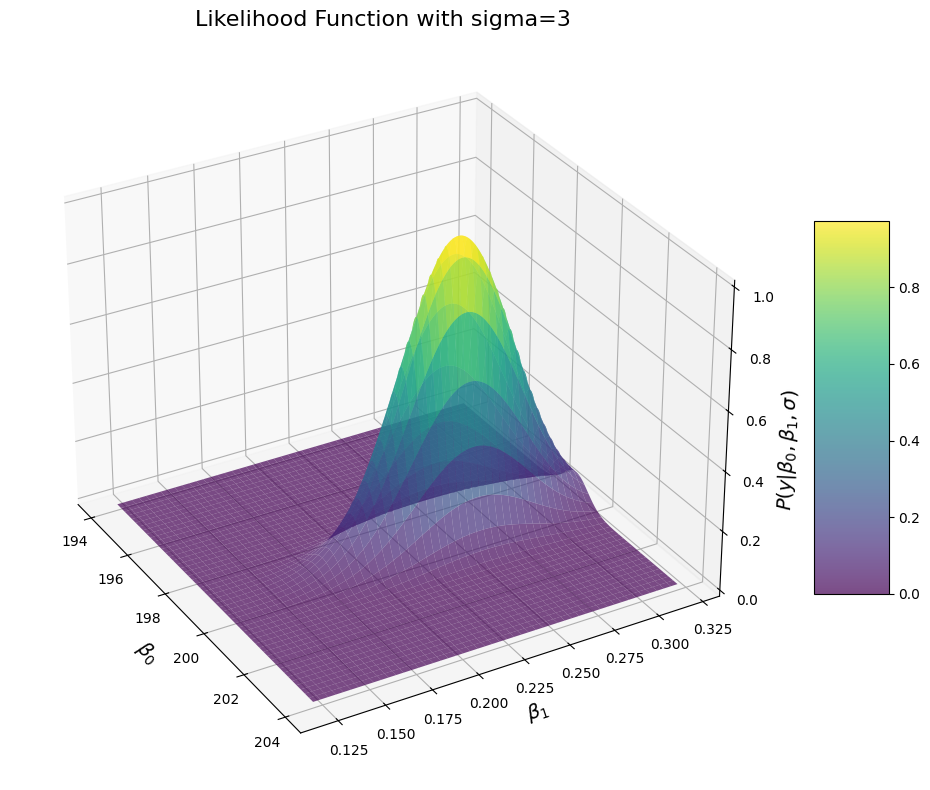

The maximum likelihood of the data is observed at:
b0=199.42
b1=0.25


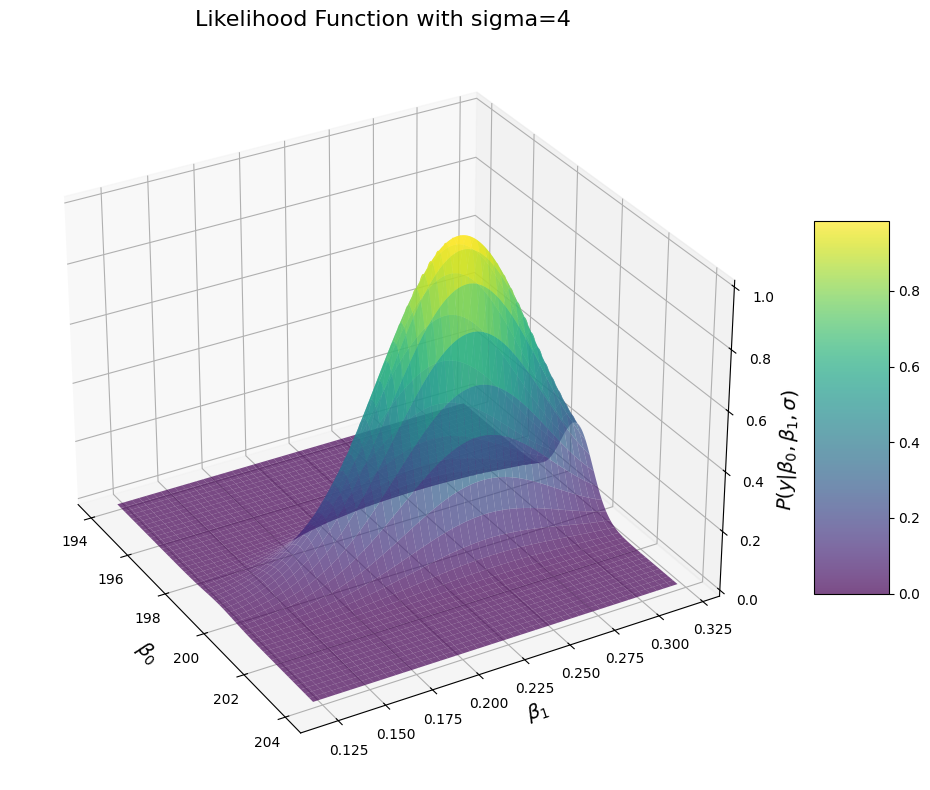

The maximum likelihood of the data is observed at:
b0=199.42
b1=0.25


In [192]:
# Set the parameters:
beta_0_gt = np.mean(flipper_length_mm)
beta_1_gt = 0.22
error_mu = 0
error_sigma = 2

x_centered = flipper_length_mm - beta_0_gt
# Simulate some data:
y = linear_mdl(x_centered, beta_0_gt, beta_1_gt, error_mu, error_sigma)

# Plot the probability of each observation across several values of b0 and b1:
b0s = np.linspace(beta_0_gt -5, beta_0_gt + 5, 1000)
b1s = np.linspace(beta_1_gt - 0.1, beta_1_gt + 0.1, 1000)
B0s, B1s  = np.meshgrid(b0s, b1s)

# Plot the data with different values of sigma:
for sigma in [0.5, 1, 2, 3, 4]:
    y_likelihood = np.zeros(B0s.shape)
    for i, b0 in enumerate(b0s):
        for ii, b1 in enumerate(b1s):
            y_likelihood[ii, i] = lm_likelihood(y, x_centered, b0, b1, sigma)
    # Normalize by max to improve viz
    y_likelihood /= np.max(y_likelihood) 
    # Create the plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    # Plot the surface
    surf = ax.plot_surface(B0s, B1s, y_likelihood, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.7)
    # Customize the axes
    ax.set_xlabel(r'$\beta_0$', fontsize=14)
    ax.set_ylabel(r'$\beta_1$', fontsize=14)
    ax.set_zlabel(r'$P(y|\beta_0, \beta_1, \sigma)$', fontsize=14)
    ax.set_title(f'Likelihood Function with sigma={sigma}', fontsize=16)
    # Adjust viewing angle for better visualization
    ax.view_init(elev=30, azim=-30)
    # Add a color bar
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.tight_layout()
    plt.show()
    plt.close()
    # Print the MLE for beta 0 and beta 1:
    print("The maximum likelihood of the data is observed at:")
    print(f"b0={B0s[np.where(y_likelihood == np.max(y_likelihood))][0]:.2f}")
    print(f"b1={B1s[np.where(y_likelihood == np.max(y_likelihood))][0]:.2f}")
    

You can see that when we increase the sigma, the distribution becomes wider, which means that the likelihood for values close to the MLE increases. That makes sense too: if $\sigma$ was truly close to 0, then we would have almost 0 error and we should be very confident in our estimates. In comparison, if the true value of sigma is larger, then we should have more noisy measurement, and there would be more values of $\beta_0$ and $\beta_1$ under which the values would be likely. Another way to see what that is obvious is to look at the formulae of the distribution.

Importantly, that doesn't mean that the likelihood of $y$ is maxed when $\sigma$ is 0. We can see that easily by comparing the likelihood observed at the MLE of $\beta_0$ and $\beta_1$:

In [193]:
# Plot the data with different values of sigma:
for sigma in [0.5, 1, 2, 3, 4]:
    y_likelihood = np.zeros(B0s.shape)
    for i, b0 in enumerate(b0s):
        for ii, b1 in enumerate(b1s):
            y_likelihood[ii, i] = lm_likelihood(y, x_centered, b0, b1, sigma) 
    # Print the MLE for beta 0 and beta 1:
    print(f"P(y|{B0s[np.where(y_likelihood == np.max(y_likelihood))][0]:.2f}, {B1s[np.where(y_likelihood == np.max(y_likelihood))][0]:.2f}, {sigma}) = {np.max(y_likelihood)}")

P(y|199.42, 0.25, 0.5) = 2.6517930632583505e-143
P(y|199.42, 0.25, 1) = 1.3141242242365102e-47
P(y|199.42, 0.25, 2) = 1.858813064911352e-30
P(y|199.42, 0.25, 3) = 6.837915284345412e-31
P(y|199.42, 0.25, 4) = 6.0772994722994155e-33


The maximal likelihood values are really low overall, but we can see that the likelihood values peak at $\sigma=2$. This implies that the data are maximally likely at $beta_0=198$, $beta_0=0.24$ and $\sigma=2$ or close thereof. So this also adds up: just as the data were most likely for $\beta_0$ and $\beta_1$ parameter close to our ground truth, the data are also most likely when the $\sigma$ is close to the ground truth. So that also makes sense.

And just as there was a function to estimate $\beta_0$ and $beta_1$ values with which the likelihood of the data are maximized, there is a function to find the value of $\sigma$ that maximizes the likelihood of the data:

$$\sigma^2 = \frac{1}{n}\sum_{i=1}^{n}[y_i-(\hat{\Beta}X)]$$

This is the matrix notation, which is equivalent to:

$$\hat{\sigma}^2 = \frac{1}{n}\sum_{i=1}^{n}[y_i-(\sum_{k=1}^{m}\beta_k x_k)]$$

Where $\hat{\beta}$ are the estimates of the beta parameters obtains with the OLS (which are teh same as the MLE of the $\beta$ parameters). This formulae looks very familiar, because it is also exactly the same as the one used before to compute the **residual sum of square error (RSS)**. It is just adjusted by dividing by the number of observation. This is also very logical: the $\sigma$ under which the data are the most likely is basically the observed amount of variation we have around our line of best fit, normalized by the number of observation, as otherwise the most likely value of $\sigma$ would always be larger when we have more data. This wouldn't be right, because the same value of $\sigma$ could be used to generate 10 data points or a 1000. 

#### Likelihood function: recap
That was a bit long, but now you know everything there is to know about the likelihood function of the linear model. To recap, we saw that for a linear model defined as:

$$y = \beta_0 + \beta_1x_i + \epsilon$$

Which is equivalent to:

$$y = \Beta X + \epsilon$$

For which the error is normally distributed and independently and identically distributed (i.i.d.):

$$\epsilon \sim \mathcal{N}(0, \sigma^2)$$

The maximal likelihood estimates of $\beta_0$, $\beta_1$ and $\sigma$ are:

$$\hat{\beta_1} = \frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$$

$$\hat{\beta_0} = \bar{y} - \hat{\beta_1}\bar{x}$$

$$\hat{\sigma}^2 = \frac{1}{n}\sum_{i=1}^{n}[y_i-(\sum_{k=1}^{m}\beta_k x_k)]$$


And finally, the likelihood of our observations given the parameters is defined as:

$$P(y|\beta_0, \beta_1, \sigma) = (\frac{1}{\sqrt{2\pi\sigma^2}})^n\prod_{i=1}^{n}exp^{-\frac{[y_i-(\sum_{k=0}^{m}{\beta_kx_k})]^2}{2\sigma^2}}$$

Which is equivalent to:

$$P(y|\beta_0, \beta_1, \sigma) = (\frac{1}{\sqrt{2\pi\sigma^2}})^n\prod_{i=1}^{n}exp^{-\frac{[y_i-X\Beta]^2}{2\sigma^2}}$$

One last thing: the current formula for the OLS assumes that there are only 2 regressors (intercept and  $x$), but we can write the formula to be a bit more general. In that case, it would be really cumbersome to write without relying on the matrix format, so we will stick to that:

$$\hat{\Beta} = (\mathbf{X}^T \mathbf{X})^{-1}\mathbf{X}^Ty$$

Okay, with that we have everything we need for the likelihood. And just one last thing: notice that I have been very precise in the phrasing in this section, the likelihood tells us the likelihood of the data under various values of the parameters of our model.

### The prior of the linear model
Now that we have the likelihood, let's have a look at the prior. We have three parameters in our model and likelihood function: $\beta_0$, $\beta_1$ and $\sigma$. Again, the prior reflect the belief we have about which values are most likely for each parameters. So you might already think about what that could look like. If you have some knowledge about what values $\beta_0$, $\beta_1$ could look like, you can imagine that the prior should be a distribution centered around those values for those parameters, with max likelihood around those values and decreasing when you go lower or higher than that. 

So yeah, some sort of a normal distribution of sorts. Typically, you wouldn't have a guess about the precise value of the parameters, but you'd know that there are some values that are more realistic than others. So you can specify the priors for these parameters with some mean and variance parameters that kind of make sense. For our particular example, since you are wonder whether there is a relationship between penguin flipper length and their weight, you can imagine that the values around 0 should be quite likely and that very large values are less likely. And for the $\beta_0$ parameter, even if you don't know the actual mean weight of penguin, you know it's probably not 500g and probably not 750Kg , so something in between. So you can play around with the normal distribution to find parameters that seem reasonable (that's how I got the parameters below):

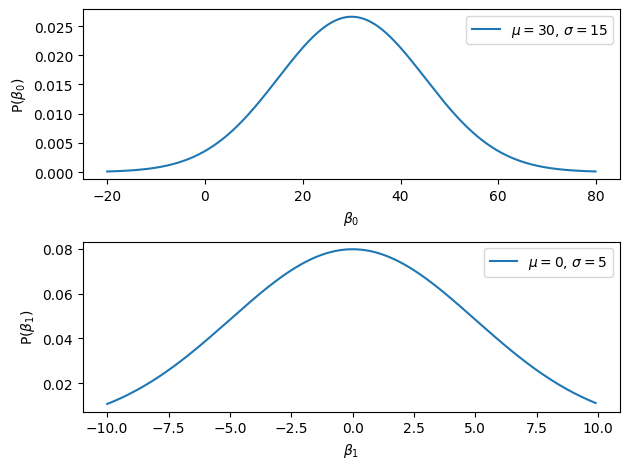

In [200]:
# Parameters for the beta0 and beta1 prior distributions:
b0_mu = 30  # I think a penguin weighting 30kg seems about right
b0_sig = 15  # To set this parameter, I played around until I got a distribution that seem reasonable
b1_mu = 0  # I think the values of b1 should be close to 0. I think there may be a relationship between the two variables, but I dont' know if it's a positive or a negative relationship, which means that positive and negative values are equally likely a priori
b1_sig = 5  # This is quite large, which means that many values of b1 are plausible

xs = np.arange(-5, 5, 0.1)  # Define values of x

fig, ax = plt.subplots(2)
xs = np.arange(b0_mu-50, b0_mu+50, 0.1)  # Define values of x
ax[0].plot(xs, [normal_pdf(x, b0_mu, b0_sig) for x in xs], label=f'$\\mu={b0_mu}$, $\\sigma={b0_sig}$')
ax[0].set_ylabel('P($\\beta_0$)')
ax[0].set_xlabel('$\\beta_0$')
ax[0].legend()

xs = np.arange(b1_mu-10, b1_mu+10, 0.1)  # Define values of x
ax[1].plot(xs, [normal_pdf(x, b1_mu, b1_sig) for x in xs], label=f'$\\mu={b1_mu}$, $\\sigma={b1_sig}$')
ax[1].set_ylabel('P($\\beta_1$)')
ax[1].set_xlabel('$\\beta_1$')
ax[1].legend()
plt.tight_layout()
plt.show()
plt.close()

These seems about right: I think most penguin weight less than 80Kg, and I don't think that the correlation between the flipper length and the penguin weight will be much more than 10 or -10, cause that would mean that for every increase of 1mm in penguin flipper length, they gain 10kg, that just feels a bit much. Are these priors good? This is one of the main reason people are skeptical about Bayesian statistics: the definition of the priors influence the posterior. Since the priors can be set up arbitrarily, some people argue that this opens up the door for subjectivity in the analysis and that we can tweak the priors to get any results we want. We will see later on that there are ways in which we can make sure that that's not the case and that our analysis is sound. But in this cpahter I will stick to picking values that seem reasonable. 

What about the $\sigma$ parameter? Well in that case, picturing something that's normally distributed would be wrong. That's because the $\sigma$ parameter has to remain positive. That's pretty logical. If the true value of $\sigma$ were zero, then you'd have zero measurement noise and the observed data would fall perfectly on your regression line. If the true value of $\sigma$ is larger than 0, then you have some error. That doesn't leave any room for a negative $\sigma$, does it? In other words, we know a priori that $\sigma$ should be 0 or larger. So we need a function that has a probability of 0 below 0. And just as was the case for the $\beta$s parameters, eventhough we don't have a precise guess for what $\sigma$ is, we can guess a range: it's not very likely that we have a $\sigma$ of 10000, because that would mean there is so much noise that we wouldn't find anything anyways. But once again, it feels like there are many kind of distributions that could be up for the task, but which one should we choose? The answer is once again: whatever is easier to work with and combine with the other distributions from a mathematical standpoint. One such distribution that is often used is the inverse gamma distribution:

$$\sigma^2 \sim \mathcal{Inverse-Gamma}(a, b)$$

And the formulae of the inverse gamma is the following:

$$f(x: \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)}(1/x)^{\alpha+1}exp(-\beta/x)$$

So let's write that in python

In [224]:
from math import gamma


def inv_gamma_pdf(x, alpha, beta):
    """
    Computes the probability density function of the inverse gamma distribution.
    
    Parameters:
    - x : float or np.ndarray
        The value(s) at which to evaluate the PDF. Must be positive.
    - alpha : float
        The shape parameter of the inverse gamma distribution. Must be positive.
    - beta : float
        The scale parameter of the inverse gamma distribution. Must be positive.
        
    Returns:
    - float or np.ndarray
        The PDF of the inverse gamma distribution evaluated at x.
    
    Notes:
    The inverse gamma distribution PDF is given by:
    
        f(x; alpha, beta) = (beta ** alpha / gamma(alpha)) * x ** (-alpha - 1) * exp(-beta / x)
    
    where `alpha` > 0 and `beta` > 0.
    """
    return (x ** (-alpha-1) / gamma(alpha)) * np.exp(-1 / x)

It's related to the $\beta$ distribution we saw in the previous chapter (not to be confused with the distribution of our $\beta$ parameter now), and it takes two parameters: $\alpha$ and $\beta$, which control the shape of the distribution. It's not as direct as the mean and the spread parameter of the normal distribution which are expressed directly in the units we are interested in, but we can just play around until we find values that seem reasonable:

C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_28060\3986028356.py:27: RuntimeWarning: divide by zero encountered in scalar power
  return (x ** (-alpha-1) / gamma(alpha)) * np.exp(-1 / x)
C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_28060\3986028356.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  return (x ** (-alpha-1) / gamma(alpha)) * np.exp(-1 / x)
C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_28060\3986028356.py:27: RuntimeWarning: invalid value encountered in scalar multiply
  return (x ** (-alpha-1) / gamma(alpha)) * np.exp(-1 / x)


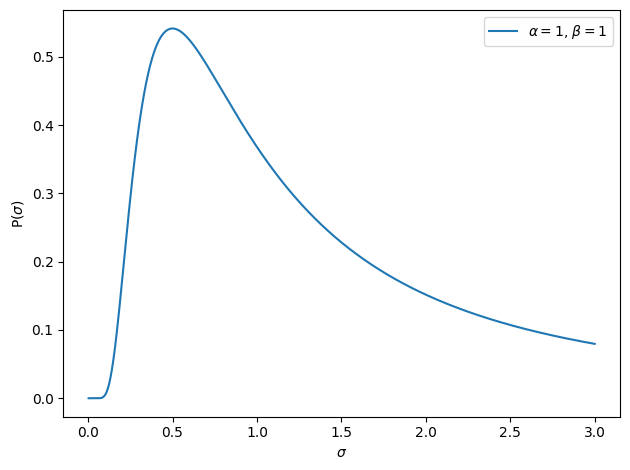

In [ ]:
from scipy.stats import invgamma

xs = np.linspace(0, 3, 1000)  # Define values of x
mu = 0
sigma = 1
fig, ax = plt.subplots()
ax.plot(xs, [inv_gamma_pdf(x, 1, 1) for x in xs], label=f'$\\alpha={1}$, $\\beta={1}$')
ax.set_ylabel('P($\\sigma$)')
ax.set_xlabel('$\\sigma$')
ax.legend()
plt.tight_layout()
plt.show()
plt.close()

I ended up with 1 and 1, seems about reasonable: small variance values are most likely, but larger ones are also not too unlikely. 